# ConvLSTM

Paper: https://arxiv.org/pdf/1506.04214.pdf

**ConvLSTM结构图**

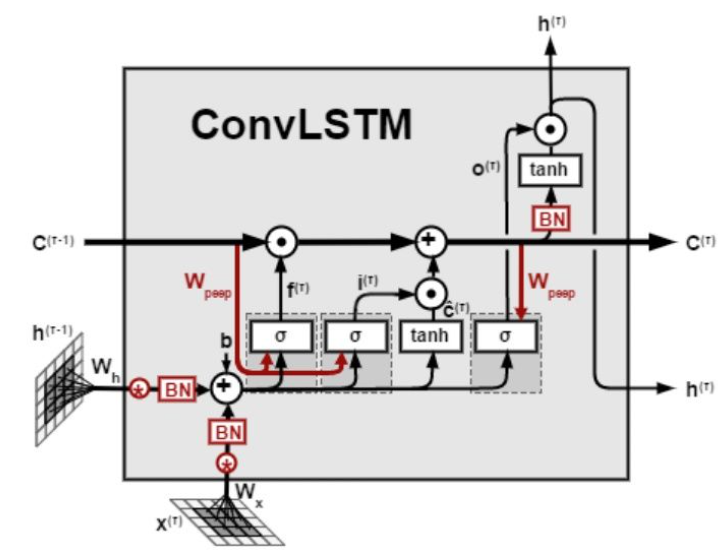

**ConvLSTM公式**

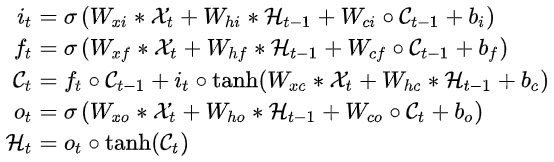

ConvLSTM是LSTM的变体，改变主要是**W的权值计算变成了卷积运算**，这样可以提取出图像的特征。还有值得注意的是，LSTM计算单元内的权值是共享的，每层LSTM都共享一份权值。

**构建ConvLSTMCell**

In [10]:
import torch
import torch.nn as nn


class ConvLSTMCell(nn.Module):
    def __init__(self,input_dim,hidden_dim,kernel_size,bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """
        super(ConvLSTMCell,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size# 卷积核为一个数组
        self.padding_size = kernel_size[0]//2,kernel_size[1]//2# 填充为高和宽分别填充的尺寸
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,# 4* 是因为后面输出时要切4片
                              kernel_size=self.kernel_size,
                              padding=self.padding_size,
                              bias=self.bias)
        
    def forward(self,input_tensor,cur_state):
        # input_tensor是X(T),h_cur是h(T-1),c_cur是C(T-1)
        h_cur,c_cur = cur_state
        combined = torch.cat((input_tensor,h_cur),dim=1)
        combined_conv = self.conv(combined)
        cc_f,cc_i,cc_o,cc_g = torch.split(combined_conv,self.hidden_dim,dim=1)
        
        f = torch.sigmoid(cc_f)
        i = torch.sigmoid(cc_i)
        o = torch.sigmoid(cc_o)
        g = torch.sigmoid(cc_g)
        
        # 这里的乘是矩阵对应元素相乘，哈达玛乘积 
        c_next = f*c_cur+i*g
        h_next = o*nn.Tanh(c_next)
        
    # 初始化返回的参数        
    def init_hidden(self,batch_size,image_size):
        height,width = image_size
        # 返回两个是因为cell的尺寸与h一样
        return (torch.zeros(batch_size,self.hidden_dim,height,width,device=self.conv.weight.device),
               torch.zeros(batch_size,self.hidden_dim,height,width,device=self.conv.weight.device))

后面h(t)会当作后面层的x(t)作为输入使用，所以与x(t)的组成成分应该也是一样的。

**构建ConvLSTM**

In [11]:
class ConvLSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,kernel_size,num_layers,batch_first=False,bias=False,return_all_layers=False):
        """
        Parameters:
            input_dim: Number of channels in input
            hidden_dim: Number of hidden channels
            kernel_size: Size of kernel in convolutions
            num_layers: Number of LSTM layers stacked on each other
            batch_first: Whether or not dimension 0 is the batch or not
            bias: Bias or no bias in Convolution
            return_all_layers: Return the list of computations for all layers
            Note: Will do same padding.
        Input:
            A tensor of size B, T, C, H, W or T, B, C, H, W
        Output:
            A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
                0 - layer_output_list is the list of lists of length T of each output
                1 - last_state_list is the list of last states
                        each element of the list is a tuple (h, c) for hidden state and memory
        Example:
            >> x = torch.rand((32, 10, 64, 128, 128))
            >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
            >> _, last_states = convlstm(x)
            >> h = last_states[0][0]  # 0 for layer index, 0 for h index
        """
        super(ConvLSTM,self).__init__()
        
        self._check_kernel_size_consistency(kernel_size)
        
        #确保'kernel_size'和'hidden_dim'都是列表，且列表长度 == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size,num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim,num_layers)
        if not len(kernel_size) == len(hidden_dim)==num_layers:
            raise ValueError('Inconsistent list length.')
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        #为了储存每一层的参数尺寸
        cell_list = []
        for i in range(0,num_layers):
            #注意这里利用lstm单元得出到了输出h，h再作为下一层的输入，依次得到每一层的数据维度并储存
            cur_input_dim = input_dim if i==0 else self.hidden_dim[i-1]
            #将上面循环得到的每一层的参数尺寸/维度，储存在self.cell_list中，后面会用到
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim,
                                          kernel_size=self.kernel_size,
                                          bias=self.bias))
        #这里用了ModuLelist函数，模块化列表
        self.cell_list = nn.ModuleList(cell_list)
    
    #input_tensor 是一个五维数据(t时间步,b输入batch_ize,c输出数据通道数--维度,h,w图像高乘宽)
    def forward(self,input_tensor,hidden_state=None):
        #先调整一下输出数据的排列
        if self.batch_first:
            input_tensor = input_tensor.permute(1,0,2,3,4)
        #取出图片的数据，供下面初始化使用
        b,_,_,h,w = input_tensor.size()
        #初始化hidd_state,利用后面和lstm单元中的初始化函数
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        layer_state_list = []
        seq_len = input_tensor.size(1)
        
        #初始化输入数据
        cur_layer_input = input_tensor
        
        for layer_idx in range(self.num_layers):
            h,c = hidden_state[layer_idx]
            output_inner = []
            
            for t in range(seq_len):
                #每一个时间步都更新 h,c
                #这里self.cell_list是一个模块(容器)
                h,c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:,t,:,:,:],cur_state=[h,c])
                #储存输出，注意这里 h 就是此时间步的输出
                output_inner.append(h)
                
            #这一层的输出作为下一次层的输入
            layer_output = torch.stack(output_inner,dim=1)
            cur_layer_input = layer_output
            layer_output_list.append(layer_output)
            layer_state_list.append([h,c])
            
        #选择要输出所有数据，还是输出最后一层的数据 
        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            layer_state_list = layer_state_list[-1:]
        
        return layer_output_list,layer_state_list
        
    def _init_hidden(self,batch_size,image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size,image_size))
        return init_states
    
    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

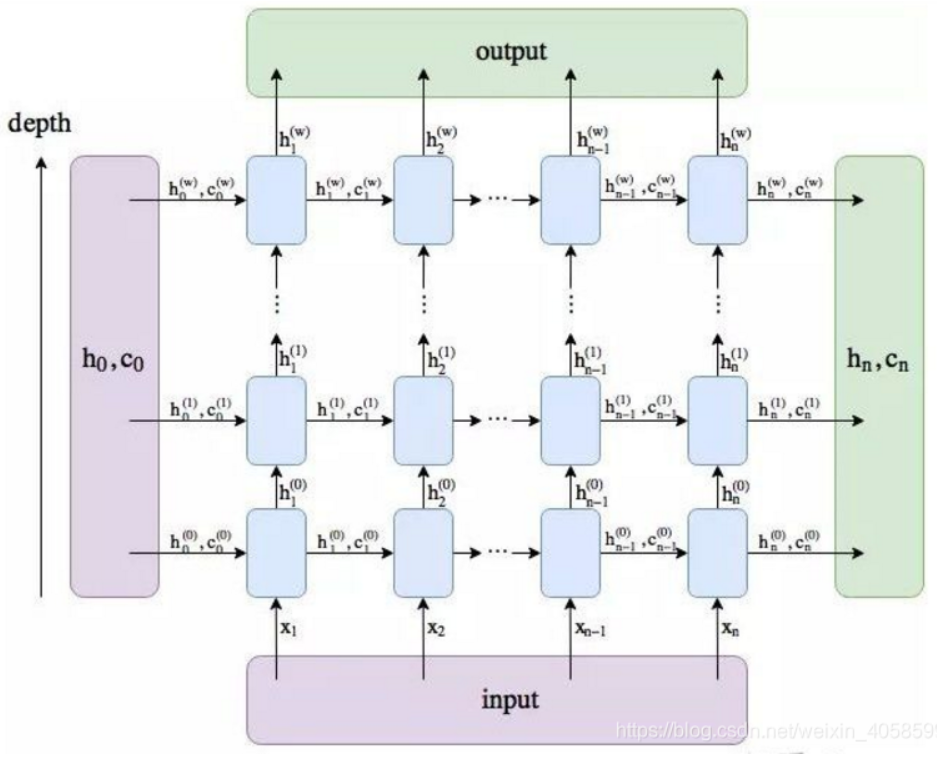